In [2]:
from distutils.dir_util import copy_tree

from_dir = '../input/forknet'
to_dir = ''

copy_tree(from_dir, to_dir)
!pip install torchsummary
!pip install hiddenlayer

In [1]:
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from mcmc_samplers import SGHMCSampler,LossModule
from ResForkNet import *
import utils as ut
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchsummary import summary
import numpy as np
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, utils
from collections import OrderedDict
import matplotlib.pyplot as plt
import hiddenlayer as hl
from IPython.display import display, clear_output

device = "cuda:0" if torch.cuda.is_available() else "cpu"
print(device)

cpu


In [2]:
transform = ut.ToTensor()
stocks = ['AAPL','AMZN','GOOGL','HPQ','INTC','MSFT','NTAP','NVDA','SPY','T','XRX']
dataset = ut.TechnicalPortfolioTimeSeries(components = stocks, window = 30, pred_window = 7,transform = transform)
lengths = [int(len(dataset)*0.8), len(dataset)-int(len(dataset)*0.8)]
train_set, test_set = torch.utils.data.random_split(dataset, lengths)
train_loader = DataLoader(train_set, batch_size=128,drop_last = True,
                        shuffle=True, num_workers=0)
test_loader = DataLoader(test_set, batch_size=len(test_set),
                        shuffle=False, num_workers=0)

/usr/local/lib/python3.5/dist-packages/sklearn/preprocessing/data.py:323: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)


(3837, 60, 330) (3837, 11)


In [3]:
model = ResForkNet(n_dependents = len(stocks), num_inputs = 60, timesteps = 30, num_channels = [128]*2)
#model.load_state_dict(torch.load('model_60',map_location = torch.device(device)))
model = model.to(device)
summary(model, input_size = (60,30*len(stocks)))

torch.Size([1, 3840])
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv1d-1              [-1, 128, 32]          23,168
            Conv1d-2              [-1, 128, 32]          23,168
            Conv1d-3              [-1, 128, 32]          23,168
           Chomp1d-4              [-1, 128, 30]               0
           Chomp1d-5              [-1, 128, 30]               0
           Chomp1d-6              [-1, 128, 30]               0
              ReLU-7              [-1, 128, 30]               0
              ReLU-8              [-1, 128, 30]               0
              ReLU-9              [-1, 128, 30]               0
          Dropout-10              [-1, 128, 30]               0
          Dropout-11              [-1, 128, 30]               0
          Dropout-12              [-1, 128, 30]               0
           Conv1d-13              [-1, 128, 32]          49,280
           Conv1d

graph = hl.build_graph(model.cpu(), torch.zeros([1, 67, 29*len(stocks)]))
graph.save(path="Network" , format="png")
graph

In [ ]:
loss_fn = torch.nn.MSELoss(reduction='sum')
#optimizer = optim.Adam([{'params':model.subnets[0].parameters(), 'lr':1e-10}], lr = 1e-5)
optimizer = optim.Adam(model.parameters(), lr=1e-4)
losses = train(model, train_loader, test_loader, loss_fn, optimizer, 200)
loss_trend = pd.DataFrame.from_dict(losses)
loss_trend.plot(kind='line')

---------------  START TRAINING  ---------------
Epochs:[13/200] >---------------------- train_loss: 2285985.25, val_loss: 11244506.0

In [ ]:
%matplotlib inline
fig, axs = plt.subplots(len(stocks),1,figsize=(30,10))
model = model.to(device)
for s in range(len(stocks)):
    test_data, test_labels = torch.Tensor(dataset.X[-100:]).type(torch.FloatTensor).to(device), torch.Tensor(dataset.Y[-100:]).type(torch.FloatTensor).to(device)
    with torch.no_grad():
        output = torch.squeeze(model(test_data)[:,s])
    
    if len(stocks) == 1:
        axs.plot(range(len(test_data)), test_labels.cpu(), label = 'true_{}'.format(stocks[s]))
        axs.plot(range(len(test_data)), output.cpu(), label = 'pred_{}'.format(stocks[s]))
        axs.legend()
    else:
        axs[s].plot(range(len(test_data)), test_labels[:,s].cpu(), label = 'true_{}'.format(stocks[s]))
        axs[s].plot(range(len(test_data)), output.cpu(), label = 'pred_{}'.format(stocks[s]))
        axs[s].legend()
plt.show()

In [4]:
loss_fn = torch.nn.MSELoss(reduction='sum')
lm = LossModule(model,train_loader, loss_fn, N = len(train_set))
SGHMC = SGHMCSampler(lm, num_burn_in_steps=3000, lr = 0.0007, keep_every=100)
SGHMC.sample(nsamples=350)
sampled_weights = SGHMC.sampled_weights
torch.save(model.state_dict(),"model_60")

cpu
23


TypeError: sample() missing 2 required positional arguments: 'train' and 'model'

In [ ]:
#test_data, test_labels = next(iter(test_loader))
#test_data = test_data.to(device)
#test_data, test_labels = test_data[-100:], test_labels[-100:]
%matplotlib inline
fig, axs = plt.subplots(len(stocks),1,figsize=(30,30))
for s in range(len(stocks)):
    test_data, test_labels = torch.Tensor(dataset.X[-100:]).type(torch.FloatTensor).to(device), torch.Tensor(dataset.Y[-100:]).type(torch.FloatTensor).to(device)
    
    output = torch.zeros([len(test_data),len(sampled_weights)]).to(device)

    for i, set_params in enumerate(sampled_weights):       
        state_dict = {}
        for k,(name, param) in enumerate(model.named_parameters()):
            state_dict[name] = torch.from_numpy(set_params[k])
        state_dict_it = OrderedDict(state_dict)
        model.load_state_dict(state_dict_it, strict=False)
        with torch.no_grad():
            output[:,i] = torch.squeeze(model(test_data)[:,s])
           

    percentile5, percentile95 = np.percentile(output.cpu().numpy(),5, axis=1), np.percentile(output.cpu().numpy(),95, axis=1)
    mean = torch.mean(output, 1)
    if len(stocks) == 1:
        axs.plot(range(len(test_data)), test_labels.cpu(), label = 'true_{}'.format(stocks[s]))
        axs.plot(range(len(test_data)), mean.cpu(), label = 'pred_{}'.format(stocks[s]))
        axs.fill_between(range(len(test_data)), percentile5, percentile95, label = 'uncertainty_{}'.format(stocks[s]), alpha=0.3)
        axs.legend()
    else:
        axs[s].plot(range(len(test_data)), test_labels[:,s].cpu(), label = 'true_{}'.format(stocks[s]))
        axs[s].plot(range(len(test_data)), mean.cpu(), label = 'pred_{}'.format(stocks[s]))
        axs[s].fill_between(range(len(test_data)), percentile5, percentile95, label = 'uncertainty_{}'.format(stocks[s]), alpha=0.3)
        axs[s].legend()
plt.savefig("Stocks.png")
plt.show()

In [24]:
window = 30
pred_window = 7
num_f = 60
trains = []
for i in range(len(dataset.merged_df)-window-pred_window, len(dataset.merged_df)-window):
    stack = []
    for j in range(0,len(dataset.merged_df.columns), num_f):
        stack.append(np.transpose(dataset.norm_df[i:window+i, j:j+num_f]))

    stack = np.concatenate(stack, axis = 1)
    print(stack.shape)
    trains.append(stack)
new_data = np.array(trains)
print(new_data.shape)

(60, 330)
(60, 330)
(60, 330)
(60, 330)
(60, 330)
(60, 330)
(60, 330)
(7, 60, 330)


torch.Size([107, 11])


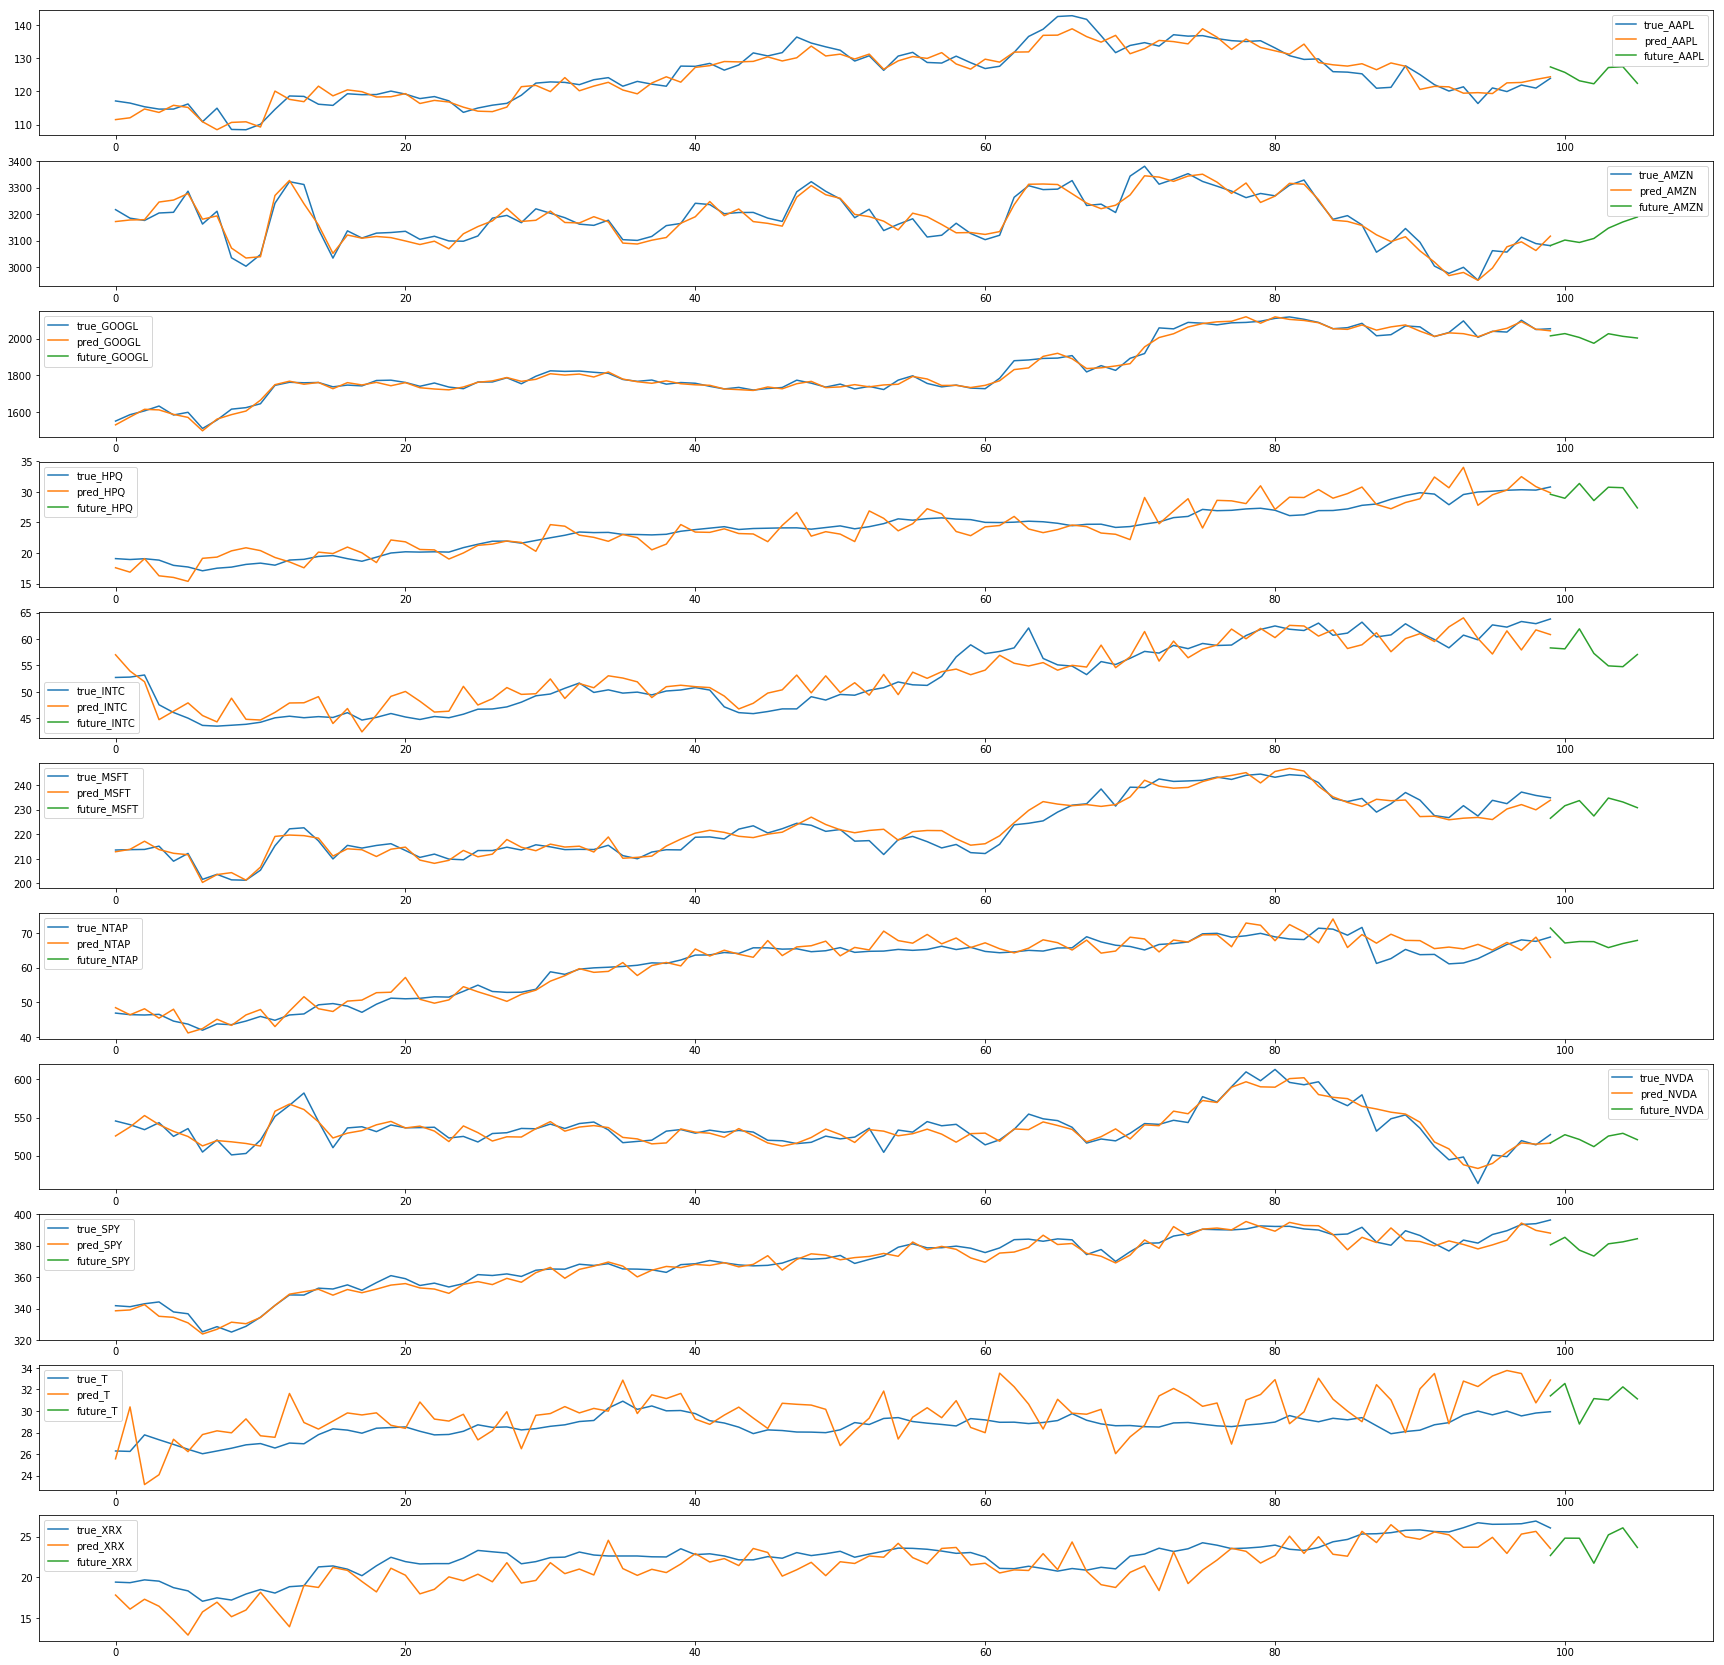

In [36]:
#test_data, test_labels = next(iter(test_loader))
#test_data = test_data.to(device)
#test_data, test_labels = test_data[-100:], test_labels[-100:]
%matplotlib inline
fig, axs = plt.subplots(len(stocks),1,figsize=(30,30))
for s in range(len(stocks)):
    test_data, test_labels = torch.Tensor(dataset.X[-100:]).type(torch.FloatTensor).to(device), torch.Tensor(dataset.Y[-100:]).type(torch.FloatTensor).to(device)
    test_data = torch.cat([test_data, torch.Tensor(new_data).type(torch.FloatTensor).to(device)], axis = 0)
    output = torch.zeros([len(test_data),len(sampled_weights)]).to(device)

    for i, set_params in enumerate(sampled_weights):       
        state_dict = {}
        for k,(name, param) in enumerate(model.named_parameters()):
            state_dict[name] = torch.from_numpy(set_params[k])
        state_dict_it = OrderedDict(state_dict)
        model.load_state_dict(state_dict_it, strict=False)
        with torch.no_grad():
            output[:,i] = torch.squeeze(model(test_data)[:,s])
           

    percentile5, percentile95 = np.percentile(output.cpu().numpy(),5, axis=1), np.percentile(output.cpu().numpy(),95, axis=1)
    mean = torch.mean(output, 1)
    if len(stocks) == 1:
        axs.plot(range(len(test_data)), test_labels.cpu(), label = 'true_{}'.format(stocks[s]))
        axs.plot(range(len(test_data)), mean.cpu(), label = 'pred_{}'.format(stocks[s]))
        axs.fill_between(range(len(test_data)), percentile5, percentile95, label = 'uncertainty_{}'.format(stocks[s]), alpha=0.3)
        axs.legend()
    else:
        axs[s].plot(range(len(test_labels)), test_labels[:,s].cpu(), label = 'true_{}'.format(stocks[s]))
        axs[s].plot(range(len(test_data)), mean.cpu(), label = 'pred_{}'.format(stocks[s]))
        axs[s].fill_between(range(len(test_data)), percentile5, percentile95, label = 'uncertainty_{}'.format(stocks[s]), alpha=0.3)
        axs[s].legend()
plt.savefig("Stocks.png")
plt.show()